# Tutorial and Exercise on GNNs using PyG

PyTorch Geometric (PyG) is a library to write and train GNNs:
[https://pytorch-geometric.readthedocs.io/en/latest/index.html](https://pytorch-geometric.readthedocs.io/en/latest/index.html)

We will use it to write and train some simple GNNs for node and graph classification. The tutorials are adapted from the official PyG Tutorials and merged into one file.

In [4]:
import torch
import torch_geometric as tg

import networkx as nx
import matplotlib.pyplot as plt


## Semi-Supervised Learning using simple GNN

We will first look at an example using semi-supervised learning for the simple example of  [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. We are interested in detecting communities that arise from the member's interaction and will use semi-supervised learning.

There are 4 class labels in the graph, and one node of each class is already labeled and can be used for training. The task is to predict the classes of all the other nodes in the graph.

Most of the common graph data sets used in the evaluation or methods are directly available in the PyG either inline if they are small (as here) or to be downloaded an cached.

We will use the notation here to write the full class path, so that it is easier to distinguish between classes and functions in `torch_geometric` (imported as `tg` here) and `torch` (imported as `torch`).

We will first write some information about the data sets and the graphs within.



In [5]:
dataset = tg.datasets.KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


Let us look at some additional information from the graph, there is only one in the dataset.

In [6]:
# Get the first graph object.
data = dataset[0]

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


As we see the feature vector for each of the 34 nodes is also a vector of length 34. As with many deep-learning approaches we do not actually need to know what information is stored within.

All the nodes already have labels (the ground truth data) and we are only supposed to use the labels in the training mask.

In [7]:
print(data.y)
print(data.train_mask)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


Graph information is stored in the edge index array. It can easily be converted to the adjacency matrix (for small graphs).

In [8]:
adj_matrix = tg.utils.to_dense_adj(data.edge_index)
print(adj_matrix)

tensor([[[0., 1., 1.,  ..., 1., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]])


We can also plot the graph directly with the labels classes

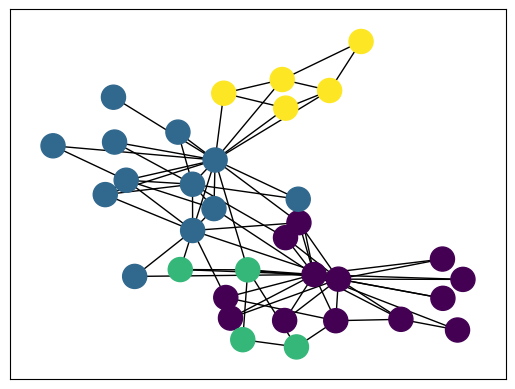

In [11]:
G = tg.utils.to_networkx(data, to_undirected=True)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=1), with_labels=False, node_color=data.y)

### Creating the GNN

Now we are read to program our first GNN! We will use the GCN approach discussed in the lecture first and add non-linear functions. We will use tanh, but you can also try out relu. The GNN should calculate an embedding and the classification. The embedding will be restricted to a vector of length 2.



In [43]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # so that we get the same result every time (i.e. same initialisation)
        torch.manual_seed(42)

        # add graph convolutional layers and slowly decrease the size of the hidden variable.
        self.conv1 = tg.nn.GCNConv(dataset.num_features, 8)
        self.conv2 = tg.nn.GCNConv(8, 4)
        self.conv3 = tg.nn.GCNConv(4, 2)

        # classifier
        self.fc = torch.nn.Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        # feature matrix of vector of all the nodws
        # edge index is the adjacency matrix
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)

        # Final GNN embedding space.
        h = h.tanh()

        # Apply a final (linear) classifier.
        out = self.fc(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 4)
  (conv3): GCNConv(4, 2)
  (fc): Linear(in_features=2, out_features=7, bias=True)
)


We can already run the network (untrained) and look at the embedding. They already look more organized than completely random due to the graph structure of the input.

In [44]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [2708, 2]


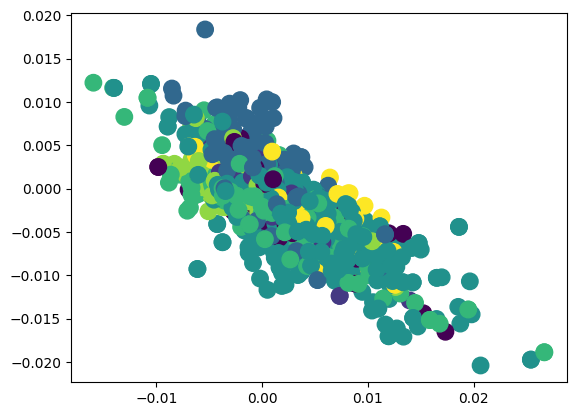

In [45]:
h_out = h.detach().cpu().numpy()
plt.scatter(h_out[:, 0], h_out[:, 1], s=140, c=data.y)

### Training

For training we need to specify the loss function and optimizer as usual. The loss function must only be calculated over the masked array.



In [46]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h


1.9871985
0.76598483
0.6160906
0.38644707


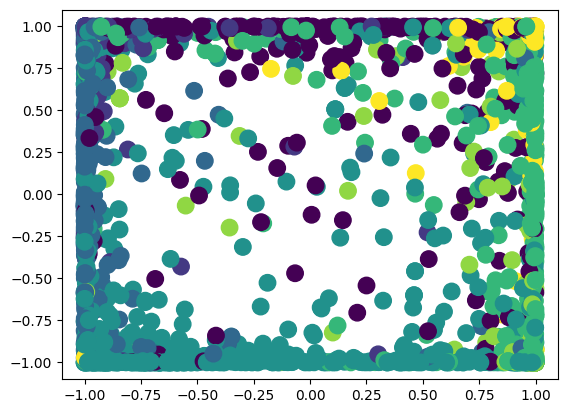

In [47]:
nr_epochs = 400
for epoch in range(nr_epochs):
    loss, h = train(data)
    if epoch % 100 == 0:
        print(loss.detach().cpu().numpy())
h_out = h.detach().cpu().numpy()
plt.scatter(h_out[:, 0], h_out[:, 1], s=140, c=data.y)

The nodes seem better separated in the embedding space now and we can calculate the final accuracy.

In [48]:
out, h = model(data.x, data.edge_index)
prediction = torch.argmax(out, dim=1)
# some datasets seem to have a test mask included, but not this one
test_mask = ~ data.train_mask
tp = (prediction[test_mask] == data.y[test_mask])
accuracy = tp.sum() / len(test_mask)
print(accuracy.cpu().numpy())

0.49889216


## Node classification with bigger data set (Cora)

We will try another data sets cora, which is a citation network where nodes represent documents and are connected by edges ir there is a citation link. Each node is described by a 1433 bag-of-words feature vector. The task is to infer the category of each document (7).

We will first try a simple MLP (GNN without edge information) and then the programming of a GNN is left as an exercise.

In [49]:
dataset = tg.datasets.Planetoid(root='data/Planetoid', name='Cora', transform=tg.transforms.NormalizeFeatures())

In [50]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


The citation between documents does not seem to be that important, could we also just determine the class by the feature vector? That would be a simple GNN that does not use the connectivity of the graph!

We will use a 2 layer dense MLP, that does not need the adjacency information but just the feature matrix.

In [51]:
class MLP(torch.nn.Module):
    def __init__(self, ds, hidden_channels, dropout_rate):
        super().__init__()
        self.fc1 = torch.nn.Linear(ds.num_features, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, ds.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [52]:
model = MLP(ds=dataset, hidden_channels=32, dropout_rate=0.2)

In [53]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

In [54]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.8247
Epoch: 020, Loss: 1.5251
Epoch: 030, Loss: 1.0659
Epoch: 040, Loss: 0.6532
Epoch: 050, Loss: 0.4015
Epoch: 060, Loss: 0.2810
Epoch: 070, Loss: 0.2501
Epoch: 080, Loss: 0.2133
Epoch: 090, Loss: 0.1738
Epoch: 100, Loss: 0.1787
Epoch: 110, Loss: 0.1693
Epoch: 120, Loss: 0.1598
Epoch: 130, Loss: 0.1607
Epoch: 140, Loss: 0.1402
Epoch: 150, Loss: 0.1261
Epoch: 160, Loss: 0.1211
Epoch: 170, Loss: 0.1144
Epoch: 180, Loss: 0.1043
Epoch: 190, Loss: 0.1251
Epoch: 200, Loss: 0.1078


In [55]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5980


## Exercise 1: Training a GNN

Now define another GNN using either the same convolutional layers as above or some other variants such as the GCNSage or GATv2Conv.

This time, we do not want to calculate an embedding that is smaller than the output vector as before, so we can just return the last hidden state with the dimension of the number of classes.

In [67]:
class GCN(torch.nn.Module):
    def __init__(self, ds, hidden_channels, dropout_rate):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(ds.num_features, hidden_channels)
        self.conv2 = tg.nn.GCNConv(hidden_channels, ds.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [61]:
class GCNSage(torch.nn.Module):
    def __init__(self, ds, hidden_channels, dropout_rate):
        super().__init__()
        self.conv1 = tg.nn.SAGEConv(ds.num_features, hidden_channels)
        self.conv2 = tg.nn.SAGEConv(hidden_channels, ds.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [70]:
model = GCN(ds=dataset, hidden_channels=32, dropout_rate=0.2)

In [74]:
model = GCNSage(ds=dataset, hidden_channels=32, dropout_rate=0.2)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.6598
Epoch: 020, Loss: 1.0091
Epoch: 030, Loss: 0.4524
Epoch: 040, Loss: 0.2144
Epoch: 050, Loss: 0.1485
Epoch: 060, Loss: 0.1220
Epoch: 070, Loss: 0.1107
Epoch: 080, Loss: 0.1024
Epoch: 090, Loss: 0.0984
Epoch: 100, Loss: 0.0879
Epoch: 110, Loss: 0.0797
Epoch: 120, Loss: 0.0762
Epoch: 130, Loss: 0.0722
Epoch: 140, Loss: 0.0707
Epoch: 150, Loss: 0.0647
Epoch: 160, Loss: 0.0617
Epoch: 170, Loss: 0.0616
Epoch: 180, Loss: 0.0585
Epoch: 190, Loss: 0.0559
Epoch: 200, Loss: 0.0555


In [76]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7930


As the output is 7-dimensional, it is no possible to draw it directly, but we can calculate a projection into 2 dimensions using TSNE and plot this.

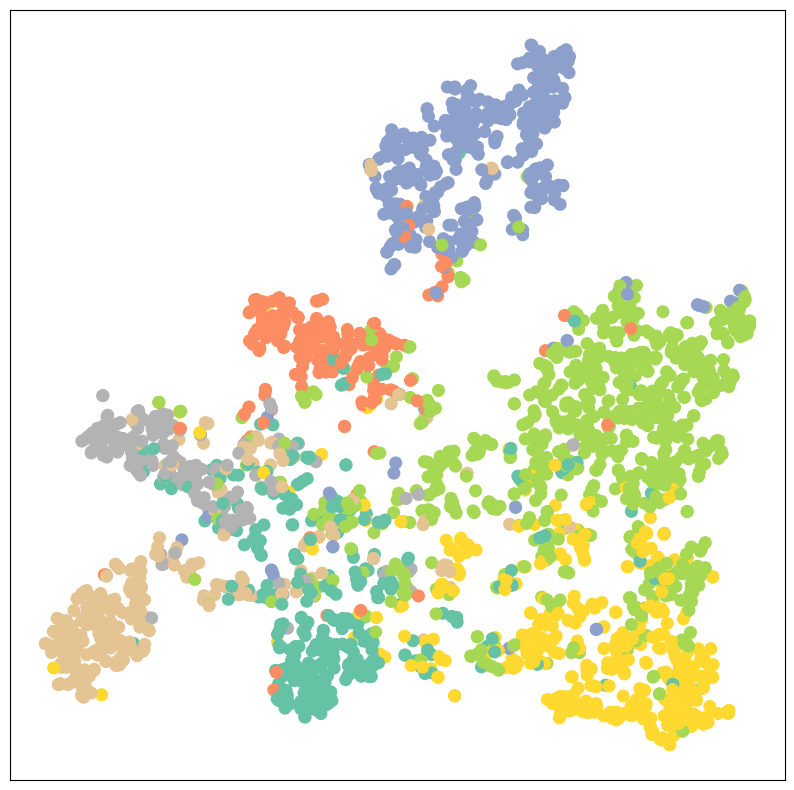

In [77]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Graph Classification

In graph classification, we want to classify entire graphs, given a dataset of graphs. For this, we can calculate a embedding for the graph and then classify this.

We will use a data set for molecular properties in which we want to predict if a molecul (given as a graph) has certain properties.

In [78]:
dataset = tg.datasets.TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset provides 188 different graphs, and the task is to classify each graph into one out of two classes.

From the first graph object of the dataset, we can see that it comes with 17 nodes (with 7-dimensional feature vectors) and 38 edges.
There is one graph label (`y=[1]`), and, in addition to previous datasets, provides  4-dimensional edge features (`edge_attr=[38, 4]`), which we will not use for the first approach.

PyTorch Geometric provides some useful utilities for working with graph datasets, *e.g.*, we can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [79]:
torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


### Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to batch the graphs before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by rescaling or padding each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension: This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of batching multiple graphs into a single giant graph with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [80]:
train_loader = tg.loader.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = tg.loader.DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2518], x=[1139, 7], edge_attr=[2518, 4], y=[64], batch=[1139], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2518], x=[1143, 7], edge_attr=[2518, 4], y=[64], batch=[1143], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 940], x=[421, 7], edge_attr=[940, 4], y=[22], batch=[421], ptr=[23])



### Training a Graph Neural Network (GNN) for graph classification

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (readout layer)
3. Train a final classifier on the graph embedding

There exists multiple readout layers in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [81]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = tg.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = tg.nn.GCNConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = tg.nn.global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.dropout(x)
        x = self.fc(x)

        return x

model = GCN(hidden_channels=64, dropout_rate=0.2)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [82]:
model = GCN(hidden_channels=64, dropout_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 251):
    train()
    train_acc = test(train_loader)
    if epoch % 10 == 0:
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 020, Train Acc: 0.7733, Test Acc: 0.6316
Epoch: 030, Train Acc: 0.7800, Test Acc: 0.6579
Epoch: 040, Train Acc: 0.7667, Test Acc: 0.6579
Epoch: 050, Train Acc: 0.7667, Test Acc: 0.6579
Epoch: 060, Train Acc: 0.7933, Test Acc: 0.6316
Epoch: 070, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 080, Train Acc: 0.7733, Test Acc: 0.7105
Epoch: 090, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 100, Train Acc: 0.7933, Test Acc: 0.6579
Epoch: 110, Train Acc: 0.8000, Test Acc: 0.6316
Epoch: 120, Train Acc: 0.7733, Test Acc: 0.7105
Epoch: 130, Train Acc: 0.7733, Test Acc: 0.6842
Epoch: 140, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 150, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 160, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 170, Train Acc: 0.8133, Test Acc: 0.6053
Epoch: 180, Train Acc: 0.7733, Test Acc: 0.6842
Epoch: 190, Train Acc: 0.7933, Test Acc: 0.6842
Epoch: 200, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 210, Train Acc: 0.8267, Test Acc:

As one can see, our model reaches around 70% test accuracy.
Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets.


### Exercise 2: Different networks

It should be possible to reach about 82% accuracy with this data set. Try to modify the GNN to achieve this using other convolutional layers. For example here, a simple convolution that does not scale the neighboring nodes by their degree works better.

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

In [87]:
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate):
        super(GCN2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GATConv(dataset.num_node_features, hidden_channels)
        self.conv2 = tg.nn.GATConv(hidden_channels, hidden_channels)
        self.conv3 = tg.nn.GATConv(hidden_channels, hidden_channels)
        self.conv4 = tg.nn.GATConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = tg.nn.global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.dropout(x)
        x = self.fc(x)

        return x

model = GCN2(hidden_channels=64, dropout_rate=0.2)
print(model)

GCN2(
  (conv1): GATConv(7, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (conv4): GATConv(64, 64, heads=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 251):
    train()
    train_acc = test(train_loader)
    if epoch % 10 == 0:
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.7733, Test Acc: 0.7105
Epoch: 020, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 030, Train Acc: 0.7800, Test Acc: 0.6842
Epoch: 040, Train Acc: 0.7933, Test Acc: 0.7632
Epoch: 050, Train Acc: 0.8200, Test Acc: 0.7368
Epoch: 060, Train Acc: 0.8333, Test Acc: 0.6316
Epoch: 070, Train Acc: 0.8267, Test Acc: 0.7368
Epoch: 080, Train Acc: 0.8067, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.7467, Test Acc: 0.5526
Epoch: 100, Train Acc: 0.7733, Test Acc: 0.6842
Epoch: 110, Train Acc: 0.7867, Test Acc: 0.6579
Epoch: 120, Train Acc: 0.8267, Test Acc: 0.7105
Epoch: 130, Train Acc: 0.7867, Test Acc: 0.6842
Epoch: 140, Train Acc: 0.8000, Test Acc: 0.6842
Epoch: 150, Train Acc: 0.8200, Test Acc: 0.7368
Epoch: 160, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 170, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 180, Train Acc: 0.8267, Test Acc: 0.7368
Epoch: 190, Train Acc: 0.8400, Test Acc: 0.7105
Epoch: 200, Train Acc: 0.7733, Test Acc: 0.6053
Epoch: 210, Train Acc: 0.8000, Test Acc:

### Exercise 3: Different data set

Returning to IMDB data sets as in our exercise classification using RNNs and transformers, there are also some IMDB datasets using graphs. The IMDB-BINARY is a data set containing the graphs of actors that perform in a movie and the (binary) classification is the type of movie (romance or action).

In [89]:
dataset = tg.datasets.TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

In [90]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)
Number of nodes: 20
Number of edges: 146
Average node degree: 7.30
Has isolated nodes: False
Has self-loops: False
Is undirected: True


As can be seen, the data set does not contain any features, just edges.

Train a classifier on this type of data set.